<a href="https://colab.research.google.com/github/thisisSHAX/ML_Ops_Project-/blob/main/Autism_Screening_ONNX_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installing required libraries

In [ ]:
!pip install wandb
!pip install onnx
!pip install skl2onnx
!pip install onnxruntime
!pip install onnxmltools

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBRegressor
from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer
import onnxruntime as rt
from skl2onnx import convert_sklearn, __version__, update_registered_converter
from skl2onnx.common.data_types import FloatTensorType, StringTensorType
from skl2onnx.common.data_types import Int64TensorType
from skl2onnx.common.shape_calculator import calculate_linear_regressor_output_shapes
from onnxmltools.convert.xgboost.operator_converters.XGBoost import convert_xgboost  # noqa
import pprint
import os
import wandb

### Loading the dataset

In [ ]:
df = pd.read_csv('https://drive.google.com/uc?export=download&id=16Pd-BdhzNMzPqPWD6XEu_XFZaGrSqFUz')

In [ ]:
df.head()

,Case_No,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,Age_Mons,Qchat-10-Score,Sex,Ethnicity,Jaundice,Family_mem_with_ASD,Who completed the test,Class/ASD Traits
0,1,0,0,0,0,0,0,1,1,0,1,28,3,f,middle eastern,yes,no,family member,No
1,2,1,1,0,0,0,1,1,0,0,0,36,4,m,White European,yes,no,family member,Yes
2,3,1,0,0,0,0,0,1,1,0,1,36,4,m,middle eastern,yes,no,family member,Yes
3,4,1,1,1,1,1,1,1,1,1,1,24,10,m,Hispanic,no,no,family member,Yes
4,5,1,1,0,1,1,1,1,1,1,1,20,9,f,White European,no,yes,family member,Yes


### Identifying categorical and numerical variables

In [ ]:
x_columns = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','Age_Mons','Sex','Ethnicity','Jaundice','Family_mem_with_ASD']

In [ ]:
cat_features = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','Sex','Ethnicity','Jaundice','Family_mem_with_ASD']

In [ ]:
num_features = list(set(x_columns) - set(cat_features))

In [ ]:
encoded_df = pd.get_dummies(df[x_columns], columns=cat_features, drop_first = True)

In [ ]:
encoded_df.sample(5)

,Age_Mons,A1_1,A2_1,A3_1,A4_1,A5_1,A6_1,A7_1,A8_1,A9_1,A10_1,Sex_m,Ethnicity_Latino,Ethnicity_Native Indian,Ethnicity_Others,Ethnicity_Pacifica,Ethnicity_White European,Ethnicity_asian,Ethnicity_black,Ethnicity_middle eastern,Ethnicity_mixed,Ethnicity_south asian,Jaundice_yes,Family_mem_with_ASD_yes
701,26,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0
580,26,0,0,1,1,0,1,1,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0
526,13,0,0,0,0,1,1,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
929,12,0,0,1,1,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0
209,36,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
x_features = list(encoded_df.columns)

In [ ]:
encoded_df.shape

(1054, 24)

### Data Splitting

In [ ]:
X = encoded_df

In [ ]:
Y = pd.get_dummies(df['Class/ASD Traits '], drop_first=True)

In [ ]:
# Splitting after One - Hot Encoding
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

X_train, X_prod, Y_train, Y_prod = train_test_split(X_train, Y_train, test_size=0.25, random_state=2) # 0.25 x 0.8 = 0.2

In [ ]:
# Splitting
train_X, test_X, train_Y, test_Y = train_test_split(df[x_columns], Y, test_size=0.2, random_state=1)

train_X, prod_X, train_Y, prod_Y = train_test_split(train_X, train_Y, test_size=0.25, random_state=2) # 0.25 x 0.8 = 0.2

In [ ]:
Y_train

,Yes
462,1
852,1
1010,1
296,0
573,1
...,...
300,1
787,1
637,0
624,1


### Creating the pipeline for deployment

In [ ]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('onehot', 
                                           OneHotEncoder(drop='first', sparse=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),                  
        ('cat', categorical_transformer, cat_features),
    ])

params = { "n_estimators": 400,
           "max_depth": 4,
           "objective": 'reg:squarederror' }

#xgb_regressor = XGBRegressor(**params)

clf1 = Pipeline(steps=[('preprocessor', preprocessor),
                      ("classifier", LogisticRegression(random_state=100))])           

clf1.fit(train_X, train_Y)



#rmse = np.sqrt(mean_squared_error(test_Y, 
#                                  reg.predict(test_X)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age_Mons']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['A1', 'A2', 'A3', 'A4', 'A5',
                                                   'A6', 'A7', 'A8', 'A9',
                                                   'A10', 'Sex', 'Ethnicity',
                                                   'Jaundice',
                                                   'Fam

In [ ]:
pred1_Y = clf1.predict(test_X)

Text(0.5, 257.44, 'Predicted label')

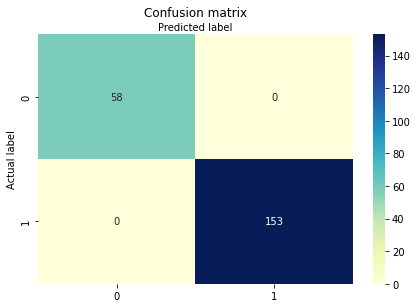

In [ ]:
# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(test_Y, pred1_Y)
cnf_matrix

# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
acc = metrics.accuracy_score(test_Y, pred1_Y)
prec = metrics.precision_score(test_Y, pred1_Y)
rec = metrics.recall_score(test_Y, pred1_Y)
f1 = metrics.f1_score(test_Y, pred1_Y)
spec = cnf_matrix.ravel()[0]/(cnf_matrix.ravel()[0]+cnf_matrix.ravel()[1])

In [ ]:
'''numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('onehot', 
                                           OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),                  
        ('cat', categorical_transformer, cat_features),
    ])

params = { "n_estimators": 400,
           "max_depth": 4,
           "objective": 'reg:squarederror' }

xgb_regressor = XGBRegressor(**params)

reg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', xgb_regressor)])           

reg.fit(train_X, train_Y)

rmse = np.sqrt(mean_squared_error(test_Y, 
                                  reg.predict(test_X)))

SyntaxError: ignored

In [ ]:
print(acc)

1.0


### Creating the ONNX Graph

In [ ]:
def convert_dataframe_schema(df, drop=None):
    inputs = []
    for k, v in zip(df.columns, df.dtypes):
        if drop is not None and k in drop:
            continue
        if v == 'int64':
            t = FloatTensorType([None, 1])
        elif v == 'float64':
            t = FloatTensorType([None, 1])
        else:
            t = StringTensorType([None, 1])
        inputs.append((k, t))
    return inputs


inputs = convert_dataframe_schema(train_X)

pprint.pprint(inputs)

[('A1', FloatTensorType(shape=[None, 1])),
 ('A2', FloatTensorType(shape=[None, 1])),
 ('A3', FloatTensorType(shape=[None, 1])),
 ('A4', FloatTensorType(shape=[None, 1])),
 ('A5', FloatTensorType(shape=[None, 1])),
 ('A6', FloatTensorType(shape=[None, 1])),
 ('A7', FloatTensorType(shape=[None, 1])),
 ('A8', FloatTensorType(shape=[None, 1])),
 ('A9', FloatTensorType(shape=[None, 1])),
 ('A10', FloatTensorType(shape=[None, 1])),
 ('Age_Mons', FloatTensorType(shape=[None, 1])),
 ('Sex', StringTensorType(shape=[None, 1])),
 ('Ethnicity', StringTensorType(shape=[None, 1])),
 ('Jaundice', StringTensorType(shape=[None, 1])),
 ('Family_mem_with_ASD', StringTensorType(shape=[None, 1]))]


In [ ]:
#update_registered_converter(
#    LogisticRegression, 'LogisticRegressor',
#    calculate_linear_regressor_output_shapes, convert_xgboost)

### Converting the pipeline to ONNX format

In [ ]:
model_onnx = convert_sklearn(
    clf1, 'pipeline_logreg',
    inputs)

### Storing the pipeline in a file

In [ ]:
MODEL_DIR = "./autismscreeningprod"
MODEL_FILE_NAME = "autismscreening_logreg.onnx"

In [ ]:
os.mkdir(MODEL_DIR)
# And save.
with open(MODEL_DIR + "/" + MODEL_FILE_NAME, "wb") as f:
    f.write(model_onnx.SerializeToString())

In [ ]:
!ls -al

total 20
drwxr-xr-x 1 root root 4096 Nov 24 21:47 .
drwxr-xr-x 1 root root 4096 Nov 24 21:19 ..
drwxr-xr-x 2 root root 4096 Nov 24 21:47 autismscreeningprod
drwxr-xr-x 4 root root 4096 Nov 18 14:35 .config
drwxr-xr-x 1 root root 4096 Nov 18 14:36 sample_data


### Uploading the pipeline to weights and biases for tracking

In [ ]:
os.environ["WANDB_API_KEY"] = "3ee9089935c4340e01c38077092a69fb10a6f6ac"

In [ ]:
wandb.init(project='autism_screening', 
           config=params, 
           tags = ['LogReg', 'OneHotEncoding'])

wandb.run.name = "LogRegProdModel"

wandb: Currently logged in as: maytune (use `wandb login --relogin` to force relogin)


In [ ]:
wandb.log( {"acc" : acc} )

In [ ]:
model_artifact = wandb.Artifact("LogReg_AutismScreening",
                                type = 'model',
                                description = 'LogReg Model for autism tracking prediction')

In [ ]:
model_artifact.add_dir(MODEL_DIR)

wandb: Adding directory to artifact (./autismscreeningprod)... Done. 0.1s


In [ ]:
wandb.run.log_artifact(model_artifact)

In [ ]:
wandb.save()
wandb.finish()

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


acc,▁
acc,1.0
